# Cassin's vireo

This notebook walks through a complete `chatter` workflow using recordings of Cassin's vireo as a worked example. It is intended to be the main, end-to-end tutorial for the Python package, showing how each component fits together.

We will:
- **Configure** `chatter` for this dataset (sampling, frequency range, segmentation options).
- **Preprocess** raw audio and extract clips that contain Cassin's vireo songs and calls.
- **Segment** clips into individual acoustic units and save standardized spectrograms.
- **Train** a convolutional variational autoencoder (VAE) on those spectrograms.
- **Extract features** from the trained model.
- **Post-process and visualize** the learned latent space and a set of derived acoustic measures.

If you are new to `chatter`, please read this notebook in its entirety and use it as a template for your own species or datasets.

The Cassin's vireo recordings come from:

Hedley, R. W. (2016). Complexity, predictability, and time homogeneity of syntax in the songs of Cassin's vireo (*Vireo cassinii*). *PLOS ONE*. [https://www.doi.org/10.1371/journal.pone.0150822](https://www.doi.org/10.1371/journal.pone.0150822)

<img src="https://cdn.download.ams.birds.cornell.edu/api/v1/asset/465321811/1200" alt="cassins vireo" width="50%"/>

&copy; Michael Stubblefield (eBird S108126823)

## Setup

In this section we import `chatter` and a few standard scientific Python libraries, then define a configuration that controls every major step of the pipeline.

Key ideas:
- **Configuration dictionary**: we start with a Python dict containing only the parameters we want to override (e.g., frequency range, preprocessing filters, segmentation thresholds). `chatter.make_config` fills in all remaining fields with sensible defaults.
- **Analyzer**: `chatter.Analyzer` orchestrates preprocessing, segmentation, and spectrogram creation. It is initialized with a config and the number of CPU cores to use (`n_jobs`).
- **Trainer**: `chatter.Trainer` wraps the autoencoder model and training loop.
- **Paths**: we keep all file system paths in clearly named variables (`raw_dir`, `input_dir`, `processed_dir`, `h5_path`, `csv_path`, `model_dir`, `output_csv_path`) so you can easily adapt this notebook to your own directory structure.

When adapting this example, you will typically:
1. Adjust the config values to fit your species or recording conditions.
2. Change the path variables to point to your own data locations.
3. Optionally change `n_jobs` based on how many CPU cores and how much RAM you have available.

First we import Chatter and a few core scientific Python libraries.
These imports are all you need to follow along with this notebook and run the full pipeline on your own data.


In [1]:
# import packages
import chatter
from pathlib import Path

This next cell defines our analysis configuration and initializes the main Chatter objects. We override a few defaults (e.g., frequency range and segmentation settings), call `make_config()` to fill in the rest, construct an `Analyzer` and `Trainer`, and then specify all the key paths on disk for this example dataset.


In [2]:
# set config parameters that depart from defaults
config = {
    # spectrogram parameters
    "fmin": 1500,
    "fmax": 7500,
    # preprocessing parameters
    "use_biodenoising": True,
    "use_noisereduce": True,
    "high_pass": 1500,
    "low_pass": 7500,
    "static": True,
    "threshold": 2,
    # simple segmentation parameters
    "simple_noise_floor": -60,
    "simple_silence_threshold_db": -50,
    "simple_min_silence_length": 0.01,
    "simple_max_unit_length": 0.8,
    "simple_min_unit_length": 0.1,
    # other parameters
    "plot_clip_duration": 5,
}
config = chatter.make_config(config)

# initialize the analyzer with the configuration
# using only 8 cores to avoid memory crash during segmentation
analyzer = chatter.Analyzer(config, n_jobs=8)
model = chatter.Trainer(config)

# set paths
raw_dir = Path("/Volumes/Expansion/data/chatter/examples/cassins_vireo/recordings/raw")
input_dir = Path(
    "/Volumes/Expansion/data/chatter/examples/cassins_vireo/recordings/clips"
)
processed_dir = Path(
    "/Volumes/Expansion/data/chatter/examples/cassins_vireo/recordings/processed"
)
h5_path = Path("/Volumes/Expansion/data/chatter/examples/cassins_vireo/spectrograms.h5")
csv_path = Path(
    "/Volumes/Expansion/data/chatter/examples/cassins_vireo/spectrograms.csv"
)
model_dir = Path("/Volumes/Expansion/data/chatter/examples/cassins_vireo/model")
output_csv_path = Path(
    "/Volumes/Expansion/data/chatter/examples/cassins_vireo/output.csv"
)
output_html_path = Path(
    "/Volumes/Expansion/data/chatter/examples/cassins_vireo/cassins_vireo_embedding.html"
)

Using 8 cores for parallel processing
Initializing convolutional variational autoencoder
Using device: mps


## Preprocessing

Raw field recordings are typically long, noisy, and contain many species. In `chatter` we break the problem into two or three stages before segmentation:

1. **Species-specific clip extraction** (`extract_species_clips`) (optional):
   - We scan the raw directory with BirdNET and keep only the time intervals where Cassin's Vireo is detected above a chosen confidence threshold.
   - Each detection is exported as a short WAV file into `input_dir`, preserving a directory structure that mirrors the original recordings.
2. **Preprocessing demo** (`demo_preprocessing`):
   - Before batch-processing everything, we take one random clip and run it through the full preprocessing pipeline in memory.
   - This produces a diagnostic plot so you can visually confirm that filters, denoising, and normalization look reasonable for your data.
3. **Batch preprocessing** (`preprocess_directory`):
   - We then apply the same preprocessing operations to every clip in `input_dir` and save standardized WAV files (same sample rate, channels, and loudness) into `processed_dir`.

For your own data, you can skip step 1 if you already have species-specific clips, but it is often useful when starting from long, mixed-species recordings.

We start by extracting clips that actually contain Cassin's vireo. `extract_species_clips()` scans long raw recordings in `raw_dir` with BirdNET, identifies segments where the target species is present above the specified confidence threshold, and writes those segments as shorter WAV files into `input_dir`.


In [3]:
# identify and export clips with cassin's vireo
analyzer.extract_species_clips(
    input_dir=raw_dir,
    output_dir=input_dir,
    species="Cassin's Vireo",
    confidence_threshold=0.99,
)

--- Found 221 audio files to process ---


Detecting 'Cassin's Vireo': 100%|██████████| 221/221 [09:51<00:00,  2.67s/it]


--- Species clip extraction complete. Clips saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/recordings/clips ---


Before launching full preprocessing, we run a quick visual check.
`demo_preprocessing()` selects a single clip, applies the same preprocessing steps that will be used in batch mode, and plots the original vs. processed spectrogram so you can confirm that the transformations look sensible.


--- Demoing preprocessing for: 1265_Cassin's_Vireo_7_230.00s-238.00s.wav ---
   Segment: 2.89s - 7.89s


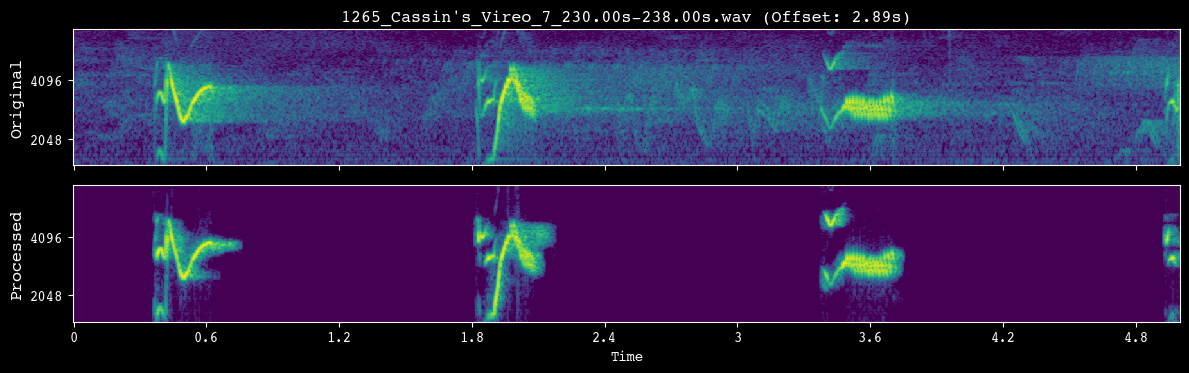

In [35]:
# demo the preprocessing pipeline
analyzer.demo_preprocessing(input_dir)

Once we are happy with the preprocessing settings, we apply them to every clip. `preprocess_directory()` walks over all files in `input_dir`, runs the full preprocessing pipeline, and writes standardized WAV files into `processed_dir`.


In [36]:
# preprocess recordings
analyzer.preprocess_directory(input_dir=input_dir, processed_dir=processed_dir)

--- Found 714 audio files to preprocess ---


Preprocessing audio: 100%|██████████| 714/714 [00:51<00:00, 13.86it/s]


--- Preprocessing complete. Standardized WAV audio saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/recordings/processed ---


## Segmentation

Once clips have been cleaned and standardized, we segment each file into shorter **acoustic units** (syllables or
notes). Chatter supports two segmentation strategies, both exposed through the `Analyzer`:

- **Simple, amplitude-based segmentation** (`simple=True`): operates directly on the waveform using an RMS
  energy threshold and minimum/maximum duration constraints.
- **Pykanto-inspired, image-based segmentation** (`simple=False`): operates on mel spectrogram images using
  the `pykanto` unit-finding algorithm.

In this notebook we:
1. Use `demo_segmentation` to visualize how the current segmentation settings behave on a few random clips. This is where you should tune thresholds, noise floors, and min/max unit lengths for your species.
2. Call `segment_and_create_spectrograms` to:
   - Run segmentation on all preprocessed WAV files in `processed_dir`.
   - Slice each file's spectrogram into fixed-size unit spectrograms.
   - Save the spectrograms to an HDF5 file (`h5_path`) and unit-level metadata (file name, onset, offset, etc.) to a CSV (`csv_path`).

The resulting `unit_df` DataFrame is the canonical representation of your segmented dataset and will be used in the modeling and postprocessing steps that follow.

Before committing to a full segmentation run, we visually inspect a few random clips. Each call to `demo_segmentation()` selects a file from `processed_dir`, runs the chosen segmentation method, and plots the spectrogram with detected unit boundaries overlaid.


--- Demoing segmentation for: 1540_Cassin's_Vireo_1_2474.00s-2479.00s.wav ---
   Segment: 0.00s - 5.00s


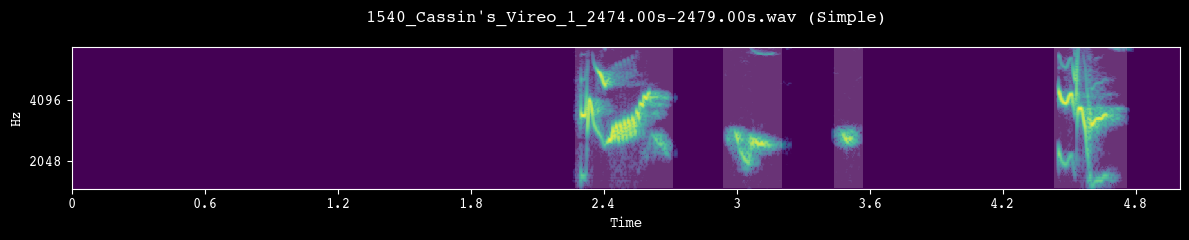

--- Demoing segmentation for: 1161_Cassin's_Vireo_52_2327.00s-2335.00s.wav ---
   Segment: 1.66s - 6.66s


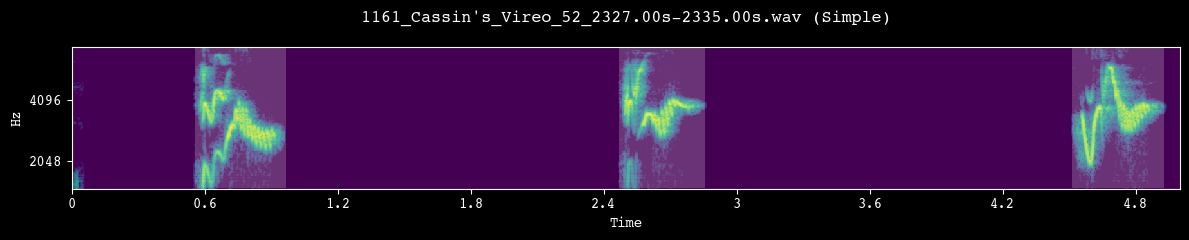

--- Demoing segmentation for: 1260_Cassin's_Vireo_2_2078.00s-2083.00s.wav ---
   Segment: 0.00s - 5.00s


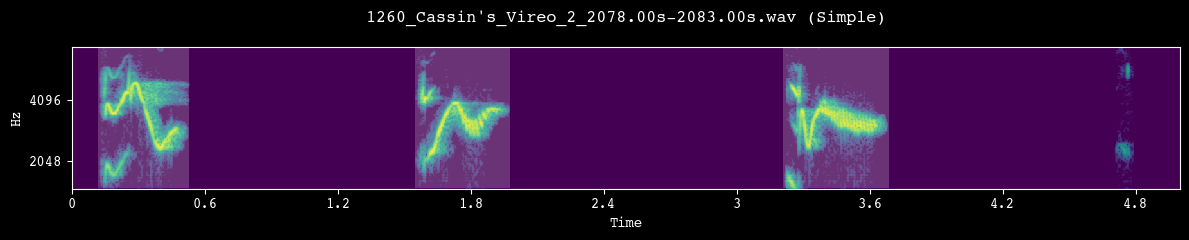

--- Demoing segmentation for: 1606_Cassin's_Vireo_2_620.00s-625.00s.wav ---
   Segment: 0.00s - 5.00s


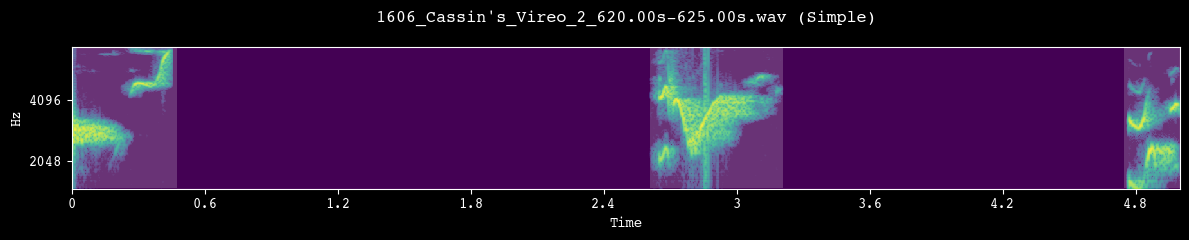

In [22]:
# preview the segmentation pipeline
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)

After we are satisfied with the segmentation behavior, we apply it to the full dataset. `segment_and_create_spectrograms()` runs segmentation on every file in `processed_dir`, slices the corresponding spectrograms into fixed-size units, writes them to `h5_path`, and builds the `unit_df` metadata table used by the model.


In [23]:
# segment units and save spectrograms
unit_df = analyzer.segment_and_create_spectrograms(
    processed_dir=processed_dir, h5_path=h5_path, csv_path=csv_path, simple=True
)


--- Found 714 files to segment using simple (amplitude-based) method ---


Segmenting and saving spectrograms: 100%|██████████| 714/714 [00:08<00:00, 84.37it/s] 



--- Data preparation complete. Created records for 2692 units ---
Spectrograms saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/spectrograms.h5
Unit metadata saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/spectrograms.csv


## Run model

With segmented unit spectrograms in hand, we fit a **convolutional variational autoencoder (VAE)** that learns a
low-dimensional representation (latent space) of Cassin's vireo syllables.

The modeling workflow here has four main steps:

1. **Train the autoencoder** (`train_ae`):
   - Uses `unit_df` and `h5_path` to draw batches of unit spectrograms.
   - Optimizes a reconstruction + KL-divergence loss over multiple epochs.
   - Saves the best-performing model parameters and a loss history CSV to `model_dir`.
2. **Reload the trained model** (`Trainer.from_trained`):
   - Demonstrates how to restore a model from disk using just the config and `model_dir`.
   - This is the entry point you would typically use in downstream analysis notebooks.
3. **Inspect reconstructions** (`plot_reconstructions`):
   - Plots original vs. reconstructed spectrograms for a subset of units.
   - Helps you visually assess whether the model is capturing relevant structure without overfitting.
4. **Extract latent features** (`extract_and_save_features`):
   - Runs all units through the encoder to obtain latent vectors and related diagnostics.
   - Writes a new CSV (`output_csv_path`) that augments `unit_df` with these model-derived features.

The remainder of the notebook shows how to work with this feature table to produce visualizations and summary statistics.

We now train the autoencoder on all segmented units.
`train_ae()` reads batches of spectrograms from `h5_path` using the indices in `unit_df`, optimizes the VAE for a fixed number of epochs, and saves the trained model and loss history to `model_dir`.


In [24]:
# train ae
model.train_ae(unit_df=unit_df, h5_path=h5_path, model_dir=model_dir, subset=1)

--- Training on the full dataset of 2692 units ---

Starting training for 100 epochs using 4 DataLoader workers...


Training model: 100%|██████████| 100/100 [09:39<00:00,  5.79s/it, loss=1171.2967]


--- Training complete. Model saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/model/model.pth ---
Loss history saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/model/loss.csv


This cell shows how to reload a previously trained model.
`Trainer.from_trained()` reconstructs the `Trainer` with weights and optimizer state from `model_dir`, which is the typical starting point for analysis notebooks that consume a trained model.


In [25]:
# load trained vae
model = chatter.Trainer.from_trained(config, model_dir)

Instantiating Trainer from pre-trained model at /Volumes/Expansion/data/chatter/examples/cassins_vireo/model...
Initializing convolutional variational autoencoder
Using device: mps
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/cassins_vireo/model/model.pth


Before trusting the model for feature extraction, we visually inspect its reconstructions. `plot_reconstructions()` shows side-by-side original and reconstructed spectrograms for a sample of units so you can check that key structure is being captured.


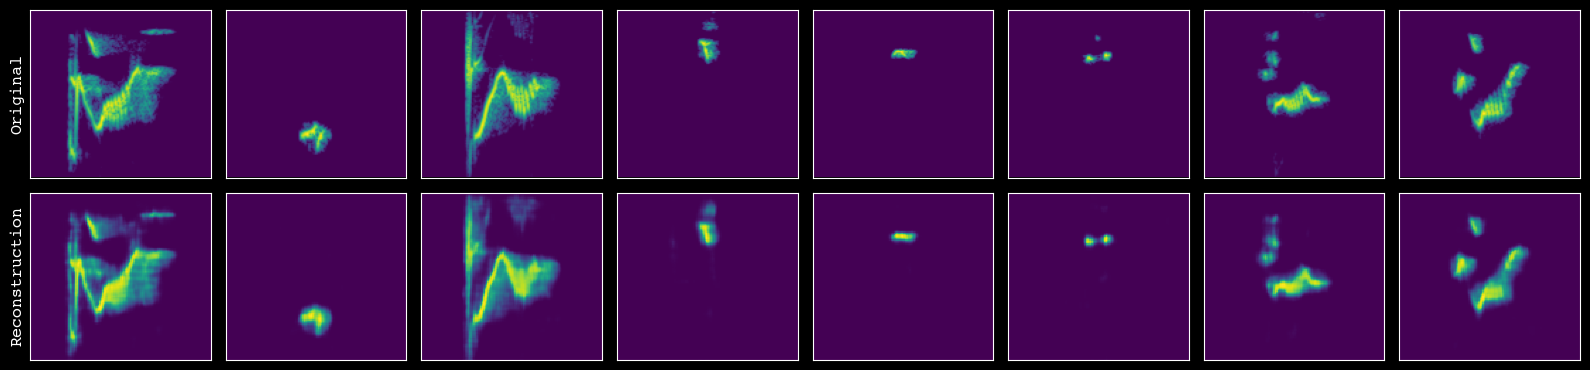

In [26]:
# assess the quality of reconstruction
model.plot_reconstructions(unit_df=unit_df, h5_path=h5_path)

Finally, we extract latent features for every unit and save them to disk. `extract_and_save_features()` runs the encoder on all spectrograms, attaches the resulting vectors and diagnostics to `unit_df`, and writes an augmented CSV to `output_csv_path`.


In [27]:
# export the latent features
output = model.extract_and_save_features(
    unit_df=unit_df,
    h5_path=h5_path,
    model_dir=model_dir,
    output_csv_path=output_csv_path,
)


--- Starting feature extraction ---
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/cassins_vireo/model/model.pth


Extracting features: 100%|██████████| 43/43 [00:06<00:00,  6.68it/s]



--- Pipeline complete. Exported data for 2692 units to /Volumes/Expansion/data/chatter/examples/cassins_vireo/output.csv ---


## Postprocessing

At this point we have a table where each row is a segmented unit and columns include:
- **Basic metadata** (original file, onset, offset).
- **Latent features** from the trained VAE.

The `FeatureProcessor` class provides a convenient interface for turning these features into visualizations and higher-level acoustic measures:

1. **Load features into a processor** (`FeatureProcessor`): wraps the DataFrame and config.
2. **Dimensionality reduction and visualization**:
   - `run_pacmap()` computes a 2D embedding of the latent space using PaCMAP, a more robust extension of UMAP.
   - `static_embedding_plot()` creates a publication-ready figure with points in latent space and overlaid spectrogram cutouts for representative units.
3. **Sequence-level structure**:
   - `assign_sequence_ids()` groups units into sequences based on temporal proximity (here using a 1-second gap threshold between units).
4. **Standard acoustic measures**:
   - `compute_frequency_statistics()` calculates summary statistics (e.g., frequency quantiles) that are commonly used in birdsong research.
5. **Neighborhood and transition statistics**:
   - `compute_density_probability()` estimates how densely populated each point is in latent space, by fitting a masked autoregressive flow with the `denmarf` package.
   - `compute_cosine_distances()` measures the path length between subsequent units within a sequence, using the cosine distance.
   - `compute_sse_resid()` fits a simple vector autoregression (VAR) model to sequences and uses residuals as a measure of transition likelihood.
6. **Export results**:
   - Finally, we write the enriched DataFrame back to `output_csv_path`, creating a single CSV that contains unit-level metadata, model-derived features, and a rich set of postprocessed measures.

You can treat this final CSV as the main output of the Chatter pipeline for downstream statistical analysis, visualization, or integration with behavioral and ecological data. Note that the reduced dimensions from PaCMAP are used *only* for visualization, and all other analyses are run on the original embeddings from the VAE.

We now wrap the feature CSV in a `FeatureProcessor`. This helper class keeps the DataFrame and config together and exposes convenience methods for dimensionality reduction, plotting, and calculating additional acoustic statistics.


In [3]:
# load in latent features
output = chatter.FeatureProcessor(analyzer.load_df(output_csv_path), config)

Attempting to load /Volumes/Expansion/data/chatter/examples/cassins_vireo/output.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/cassins_vireo/output.csv ---


To make the high-dimensional latent features easier to explore, we first compute a 2D embedding. `run_pacmap()` applies the PaCMAP algorithm to the latent vectors and stores the resulting coordinates in the feature table.


In [6]:
# run pacmap to get two-dimensional embedding for visualization
output.run_pacmap()

--- Running PaCMAP dimensionality reduction ---
--- PaCMAP complete ---


Now we create a 2D visualization of the latent space. `static_embedding_plot()` uses the PaCMAP coordinates to produce a publication-ready figure with unit points, density shading, and overlaid spectrogram callouts for informative examples. By playing around with the seed we can modify which points are shown.

--- Automatically selecting focal points from quadrants with seed 11 ---
--- Finding nearest neighbors ---
--- Creating the plot ---
--- Plotting density background (using fast 2d histogram) ---
--- Calculating callout positions and adding spectrograms ---
--- Displaying plot ---


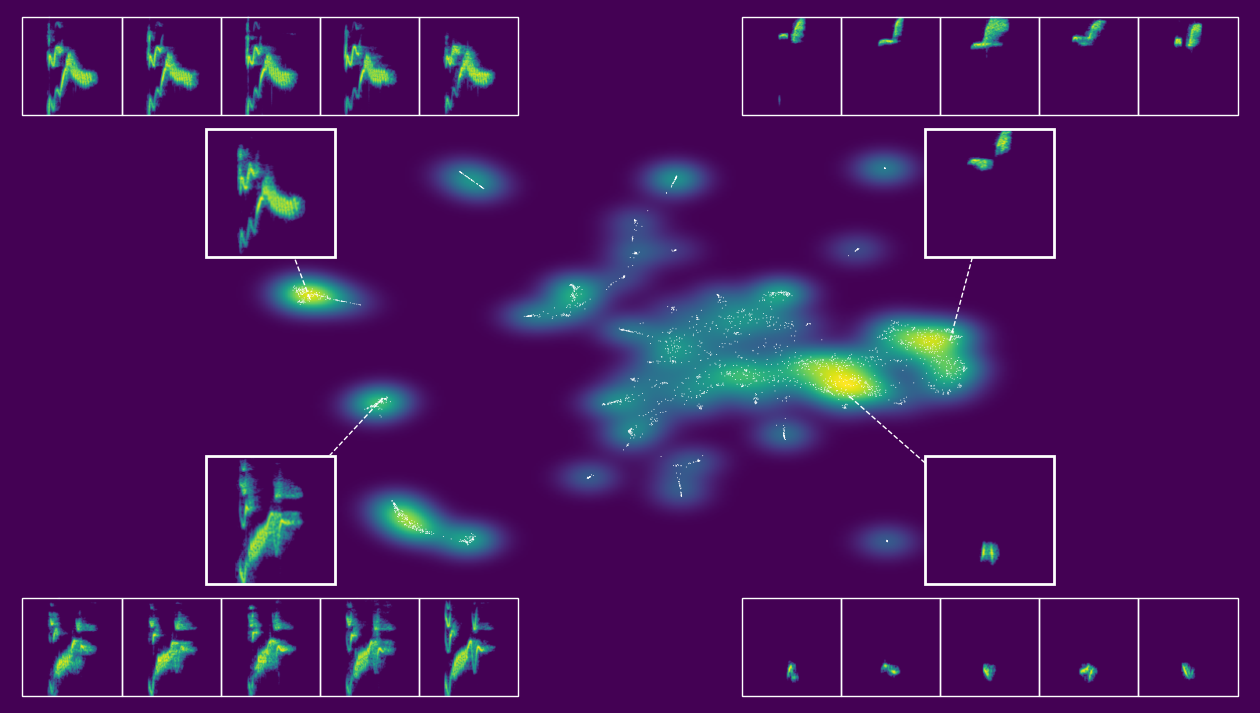

In [8]:
# create static plot
output.static_embedding_plot(
    h5_path=h5_path,
    seed=11,
    focal_quantile=0.5,
    point_size=0.5,
    point_alpha=1,
    margin=0.01,
    zoom_padding=0.42,
    num_neighbors=5,
)

We can also create an interactive version of this. The actual output of `export_interactive_embedding()` is an HTML file, but the example below is a screen capture of it.

In [5]:
# create interactive plot
output.interactive_embedding_plot(
    h5_path=h5_path, output_html_path=output_html_path, point_alpha=1, point_size=1
)

--- Encoding spectrogram thumbnails for HTML export ---


Thumbnails: 100%|██████████| 2692/2692 [00:02<00:00, 1332.59it/s]


--- Interactive HTML embedding saved to /Volumes/Expansion/data/chatter/examples/cassins_vireo/cassins_vireo_embedding.html ---


<img src="../_static/cassins_vireo_embedding.gif" alt="cassins vireo embedding" width="100%"/>

After visualizing the embedding, we group units into temporal sequences. `assign_sequence_ids()` walks through units ordered by time and starts a new `seq_id` whenever the gap between adjacent units exceeds the specified cutoff (here 1 second).

In [9]:
# assign sequence ids based on the 1-second cutoff
output.assign_sequence_ids()

--- Assigning seq_id using seq_bound = 1.0 seconds ---
--- seq_id assignment complete; total sequences: 1690 ---


Here we use `compute_frequency_statistics()` to compute standard acoustic measures familiar from birdsong research: minimum, mean, and maximum frequency.


In [10]:
# calculate standard acoustic measures used in birdsong research
output.compute_frequency_statistics(h5_path=h5_path)

--- Computing frequency statistics from spectrograms ---


Analyzing spectrograms: 100%|██████████| 2692/2692 [00:01<00:00, 1483.02it/s]

--- Frequency statistics computation complete ---


We also estimate how densely populated each point is in the latent space. `compute_density_probability()` assigns a density-based score to each unit, which can be useful for identifying rare or typical syllables.

In [11]:
# compute density probability of each unit
output.compute_density_probability()

--- Computing density probability estimates using denmarf ---
    Using 32-dimensional latent feature space.
    Fitting MAF model on 2692 samples (device: mps)...


current average log likelihood: nan: 100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]  

best average log likelihood: -41.249
    Scoring samples...
--- Density estimation complete. Added 'density_log_prob' to DataFrame ---


Next we quantify the path length between subsequent units in sequences. `compute_cosine_distances()` computes cosine distances between successive latent vectors, which can be interpreted as a measure of acoustic change rate over time.


In [12]:
# compute cosine distances between subsequent units in sequences
output.compute_cosine_distances()

--- Computing cosine distances between subsequent syllables (within seq_id) ---
--- Cosine distance calculation complete (within seq_id only) ---


Here we estimate how surprising each unit-to-unit transition is. `compute_sse_resid()` fits a simple vector autoregression (VAR) model to sequences in latent space and uses the summed squared residuals as a measure of transition likelihood (larger values indicate less expected transitions given recent context).


In [13]:
# compute the likelihood of each transition between units
output.compute_sse_resid()

--- Running global VAR model (OLS) with lag size p = 3 ---
--- Global VAR model (OLS) complete; sse_resid computed for all sequences ---


Lastly, we are able to compute the distance between any pair of sequences using `compute_dtw_distance()`. This function uses dynamic time warping with the cosine distance to flexibly measure the distance between pairs of sequences—here between #32 and #63.

In [5]:
# compute the distance between two sequences
output.compute_dtw_distance(32, 64)

1.8575730635739593

Before finishing, we save the enriched feature table back to disk. This CSV combines unit-level metadata, VAE-derived features, sequence IDs, and all postprocessed measures so it can be used in downstream analyses or other software. Note that the first unit of each sequence is given NaN for `cosine_dist` and `sse_resid`, since those values are relative to the first unit in each sequence.


In [14]:
# preview the final data frame
output.df

,source_file,unit_index,onset,offset,max_unit_length_s,h5_index,ae_feat_0,ae_feat_1,ae_feat_2,ae_feat_3,...,pacmap_x,pacmap_y,seq_id,min_freq,mean_freq,max_freq,time_bin_ms,density_log_prob,cosine_dist,sse_resid
0,hedley_2016/Wav Files 1/1113_Cassin's_Vireo_1_...,0,0.031927,0.374422,0.8,1971,1.410389,-2.699534,1.295568,0.646331,...,8.095862,-2.044903,1,1500.000000,2375.142101,7129.297213,6.25,-42.518436,NaN,NaN
1,hedley_2016/Wav Files 1/1113_Cassin's_Vireo_1_...,1,0.641451,0.873651,0.8,1972,-0.976862,0.353828,-1.931226,1.852069,...,6.673967,-2.631289,1,2138.929378,2505.763628,2936.216478,6.25,-26.115707,1.052800,62.332695
2,hedley_2016/Wav Files 1/1113_Cassin's_Vireo_1_...,2,1.439637,1.843084,0.8,1973,3.946225,-3.297062,-0.347933,0.368604,...,-13.315022,-14.799085,1,1500.000000,3724.592170,6776.916971,6.25,-37.763107,1.167537,149.182406
3,hedley_2016/Wav Files 1/1113_Cassin's_Vireo_1_...,3,3.604898,4.028662,0.8,1974,3.209291,-1.472756,0.012070,-0.722493,...,-13.210196,-14.569655,2,1500.000000,3798.581942,6524.135804,6.25,-34.966949,NaN,NaN
4,hedley_2016/Wav Files 1/1113_Cassin's_Vireo_1_...,4,4.040272,4.159274,0.8,1975,0.337892,2.038742,1.111712,0.800808,...,10.202535,2.893551,2,4575.301882,4725.160134,4936.733992,6.25,-10.372253,1.059631,43.464143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,hedley_2016/Wav Files 3/1841_Cassin's_Vireo_1_...,0,0.000000,0.121905,0.8,778,-0.982202,3.746105,1.258669,0.656011,...,9.680232,2.545646,1689,4082.121425,4608.508021,5326.771592,6.25,-12.080605,NaN,NaN
2688,hedley_2016/Wav Files 3/1841_Cassin's_Vireo_1_...,1,1.233560,1.613787,0.8,779,0.207171,-1.890158,0.973335,5.958722,...,-1.043776,-3.734445,1690,1500.000000,3639.036725,7312.345246,6.25,-46.577782,NaN,NaN
2689,hedley_2016/Wav Files 3/1841_Cassin's_Vireo_1_...,2,1.950476,2.089796,0.8,780,1.633583,2.349890,0.771327,1.764572,...,10.795265,2.308394,1690,4460.767812,4973.235868,5394.703807,6.25,-17.789322,1.130541,100.897193
2690,hedley_2016/Wav Files 3/1841_Cassin's_Vireo_1_...,3,2.385850,2.528073,0.8,781,-0.562219,0.969748,-0.693975,2.147093,...,6.591626,-2.115031,1690,1791.207173,2374.763711,3128.292871,6.25,-26.665470,0.849881,201.754410


In [15]:
# save the final data frame with all of these measures to a CSV file
output.df.to_csv(output_csv_path, index=False)